In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
from setup import load_from_checkpoint, device
from embeddings import get_input_embeddings, get_block_activations, get_final_embeddings

from probe_functions import BoardStateClassifier, LinearBoardStateClassifier

In [2]:
linear = LinearBoardStateClassifier(12, 27)
print('Linear: ')
print(sum(p.numel() for p in linear.parameters()))

mlp = BoardStateClassifier(12, 27)
print('MLP: ')
print(sum(p.numel() for p in mlp.parameters()))

Linear: 
1053
MLP: 
1209


In [3]:
for name, param in linear.named_parameters():
    print(f"{name}: {param.numel()} parameters")

fc.weight: 972 parameters
fc.bias: 81 parameters


In [4]:
class BoardStateClassifier(nn.Module):
    def __init__(self, n_embd, board_size):
        super(BoardStateClassifier, self).__init__()
        self.fc1 = nn.Linear(n_embd, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)      # Second hidden layer
        self.fc3 = nn.Linear(64, board_size * 3)  # Output layer: 3 classes per board space
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)  # No activation here, we'll apply softmax later
        return x  # logits

In [5]:
def board_from_game_seq(seq, m=3, n=3):
    no_start_seq = seq[1:]
    board = np.zeros((m, n))
    for i in range(len(no_start_seq)):
        s = no_start_seq[i]
        if s < m * n:
            row, col = s // n, s % n
            if i % 2 == 0:
                board[row][col] = 1
            else:
                board[row][col] = -1
    return board

def player_based_board_from_seq(seq, m=3, n=3):
    no_pad_seq = seq[1:]
    board = np.zeros((m, n))
    current_player = 1 if len(no_pad_seq) % 2 == 0 else -1
    
    for i, s in enumerate(no_pad_seq):
        if s < m * n:
            row, col = s // n, s % n
            board[row][col] = current_player
            current_player *= -1  # Switch perspective after each move
            
    return board

In [6]:
def generate_dataset(df, m=3, n=3):
    dataset = []
    game_seqs = df.values.tolist()
    for game_seq in game_seqs:
        for i in range(1, len(game_seq) + 1):
            trimmed_seq = game_seq[:i]
            current_board = player_based_board_from_seq(trimmed_seq, m, n)
            dataset.append((trimmed_seq, current_board))
    return dataset

In [7]:
data_dir = "data"
m, n, k = 3, 3, 3
train_data = np.load(os.path.join(data_dir,f"train_m{m}_n{n}_k{k}.npy")).astype(dtype=np.int64)
df = pd.DataFrame(train_data)
dataset = generate_dataset(df)

In [8]:
# Steps...
# 1. Load model
# 2. Get activaitons from model for each (i, j) in dataset. Create a new dataset that is (activation, j)
# 3. Construct a model to predict each element of j from activation. What kind of model can achieve this?
# 4. If we can make accurate predictions, the model has an internal representation of board state

"""What makes this different from Othello?

Othello is much more complicated, and can't be represented by a linear function. New moves can change previous moves,
and the model needs to learn how a new move affects the past state. However, here it seems like we could have a linear
function that directly maps the move token to the actual change in board state"""

model = load_from_checkpoint(out_dir='probing_checkpoints', name='ckpt2')
model.eval()
model.to(device)

/Users/rajenparekh/Desktop/Brown/2024-25/Senior Thesis/mnk_transformer/setup.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_loca

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(11, 12)
    (wpe): Embedding(10, 12)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=12, out_features=36, bias=False)
          (c_proj): Linear(in_features=12, out_features=12, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=12, out_features=48, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=48, out_features=12, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=12, out_features=11, bias=False)
)

In [9]:
sequences = [seq for seq, _ in dataset[:100000]]  # Extract input sequences from dataset
final_embeddings = get_final_embeddings(model, sequences, device)

Generating final embeddings for 100000 sequences
On sequence 0/100000


KeyboardInterrupt: 

In [ ]:
final_embeddings_last_token = [embedding[:, -1, :] for embedding in final_embeddings]
# Stack them into a single tensor (shape: [num_samples, n_embd])
final_embeddings_tensor = torch.stack(final_embeddings_last_token)

In [ ]:
final_embeddings_tensor_sq = final_embeddings_tensor.squeeze(1)

In [ ]:
final_embeddings_tensor_sq.size(1)

12

In [ ]:
def map_board_state(state):
    return {0: 0, 1: 1, -1: 2}.get(state, state)  # default to state if not in dict

# Apply the transformation to the board states
board_states = np.array([board.flatten() for _, board in dataset[:100000]])
mapped_board_states = [list(map(map_board_state, board_state)) for board_state in board_states]
board_states_tensor = torch.tensor([board_state for board_state in mapped_board_states], dtype=torch.long)

In [ ]:
board_states_tensor.shape

torch.Size([100000, 9])

In [ ]:
model = BoardStateClassifier(n_embd=final_embeddings_tensor_sq.size(1), board_size=m*n)
model.to(device)  # Move the model to the appropriate device (e.g., GPU)

# Set up loss and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy for classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Create DataLoader for batching
batch_size = 64
dataset_tensor = torch.utils.data.TensorDataset(final_embeddings_tensor_sq, board_states_tensor)
data_loader = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_idx, (embeddings, targets) in enumerate(data_loader):
        embeddings, targets = embeddings.to(device), targets.to(device)
        
        # Forward pass
        logits = model(embeddings)
        
        # Compute loss
        loss = criterion(logits.view(-1, 3), targets.view(-1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}")

Epoch 1/20, Loss: 0.3956
Epoch 2/20, Loss: 0.3497
Epoch 3/20, Loss: 0.3341
Epoch 4/20, Loss: 0.3232
Epoch 5/20, Loss: 0.3155
Epoch 6/20, Loss: 0.3101
Epoch 7/20, Loss: 0.3062
Epoch 8/20, Loss: 0.3035
Epoch 9/20, Loss: 0.3011
Epoch 10/20, Loss: 0.2988
Epoch 11/20, Loss: 0.2974
Epoch 12/20, Loss: 0.2958
Epoch 13/20, Loss: 0.2942
Epoch 14/20, Loss: 0.2933
Epoch 15/20, Loss: 0.2925
Epoch 16/20, Loss: 0.2915
Epoch 17/20, Loss: 0.2905
Epoch 18/20, Loss: 0.2895
Epoch 19/20, Loss: 0.2889
Epoch 20/20, Loss: 0.2883


In [ ]:
index = 35555
# Select one sample from final_embeddings_tensor_sq (it should be of shape [1, n_embd])
sample_embedding = final_embeddings_tensor_sq[index].unsqueeze(0).to(device)  # Add batch dimension

# Pass it through the model
model.eval()  # Make sure the model is in evaluation mode
logits = model(sample_embedding)  # Shape of logits will be [1, m * n * 3]

# Reshape the logits to [batch_size, m * n, 3] where each of the m * n board spaces has 3 logits
logits = logits.view(1, m * n, 3)

# Print the raw logits
print("Raw logits (before applying softmax):")
print(logits)

# Get the predicted class by applying argmax on the last dimension (dim=-1)
predicted_classes = torch.argmax(logits, dim=-1)  # Shape: [1, m * n]

# Print the predicted classes (board states)
print("\nPredicted board states (0, 1, 2 for each space):")
print(predicted_classes)


Raw logits (before applying softmax):
tensor([[[-24.5839,   3.0834,   2.8317],
         [  5.4631,  -8.7777,  -7.3001],
         [-31.0086,   3.3999,   3.5546],
         [  9.4622,  -5.1806,   2.2553],
         [ 13.6254,  -0.0526,  -1.4680],
         [ 20.5632,  -2.0527,  -0.4835],
         [-36.4122,   1.4490,   2.0132],
         [-14.7925,   0.7016,   0.5150],
         [-28.2748,  -0.9567,   1.4260]]], device='mps:0',
       grad_fn=<ViewBackward0>)

Predicted board states (0, 1, 2 for each space):
tensor([[1, 0, 2, 0, 0, 0, 2, 1, 2]], device='mps:0')


In [ ]:
sequence, board = dataset[index]
print(sequence)
print(board)

[9, 7, 2, 6, 0, 8]
[[ 1.  0.  1.]
 [ 0.  0.  0.]
 [-1. -1. -1.]]


In [ ]:
def evaluate_model_accuracy(model, final_embeddings_tensor_sq, board_states_tensor, device, m=3, n=3):
    model.eval()  # Set the model to evaluation mode

    correct_board_predictions = 0
    total_board_predictions = 0
    correct_space_predictions = 0
    total_space_predictions = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for index in range(len(final_embeddings_tensor_sq)):
            # Select one sample from final_embeddings_tensor_sq
            sample_embedding = final_embeddings_tensor_sq[index].unsqueeze(0).to(device)  # Add batch dimension

            # Pass the sample through the model
            logits = model(sample_embedding)  # Shape: [1, m * n * 3]

            # Reshape the logits to [1, m * n, 3]
            logits = logits.view(1, m * n, 3)

            # Get the predicted classes by applying argmax on the last dimension (dim=-1)
            predicted_classes = torch.argmax(logits, dim=-1)  # Shape: [1, m * n]

            # Get the ground truth board state for the current index and move it to the same device
            true_board_state = board_states_tensor[index].to(device)

            # Compare the predicted classes with the ground truth board state
            if torch.equal(predicted_classes.squeeze(), true_board_state):
                correct_board_predictions += 1

            total_board_predictions += 1

            correct_space_predictions += (predicted_classes.squeeze() == true_board_state).sum().item()
            total_space_predictions += true_board_state.numel()

    # Calculate accuracy: Number of correct predictions / Total predictions
    board_accuracy = correct_board_predictions / total_board_predictions
    space_accuracy = correct_space_predictions / total_space_predictions

    return board_accuracy, space_accuracy

# Example usage:
board_accuracy, space_accuracy = evaluate_model_accuracy(model, final_embeddings_tensor_sq, board_states_tensor, device)
print(f"Accuracy of model (individual spaces): {space_accuracy * 100:.2f}%")
print(f"Accuracy of model (entire board predicted correctly): {board_accuracy * 100:.2f}%")

Accuracy of model (individual spaces): 82.35%
Accuracy of model (entire board predicted correctly): 36.55%


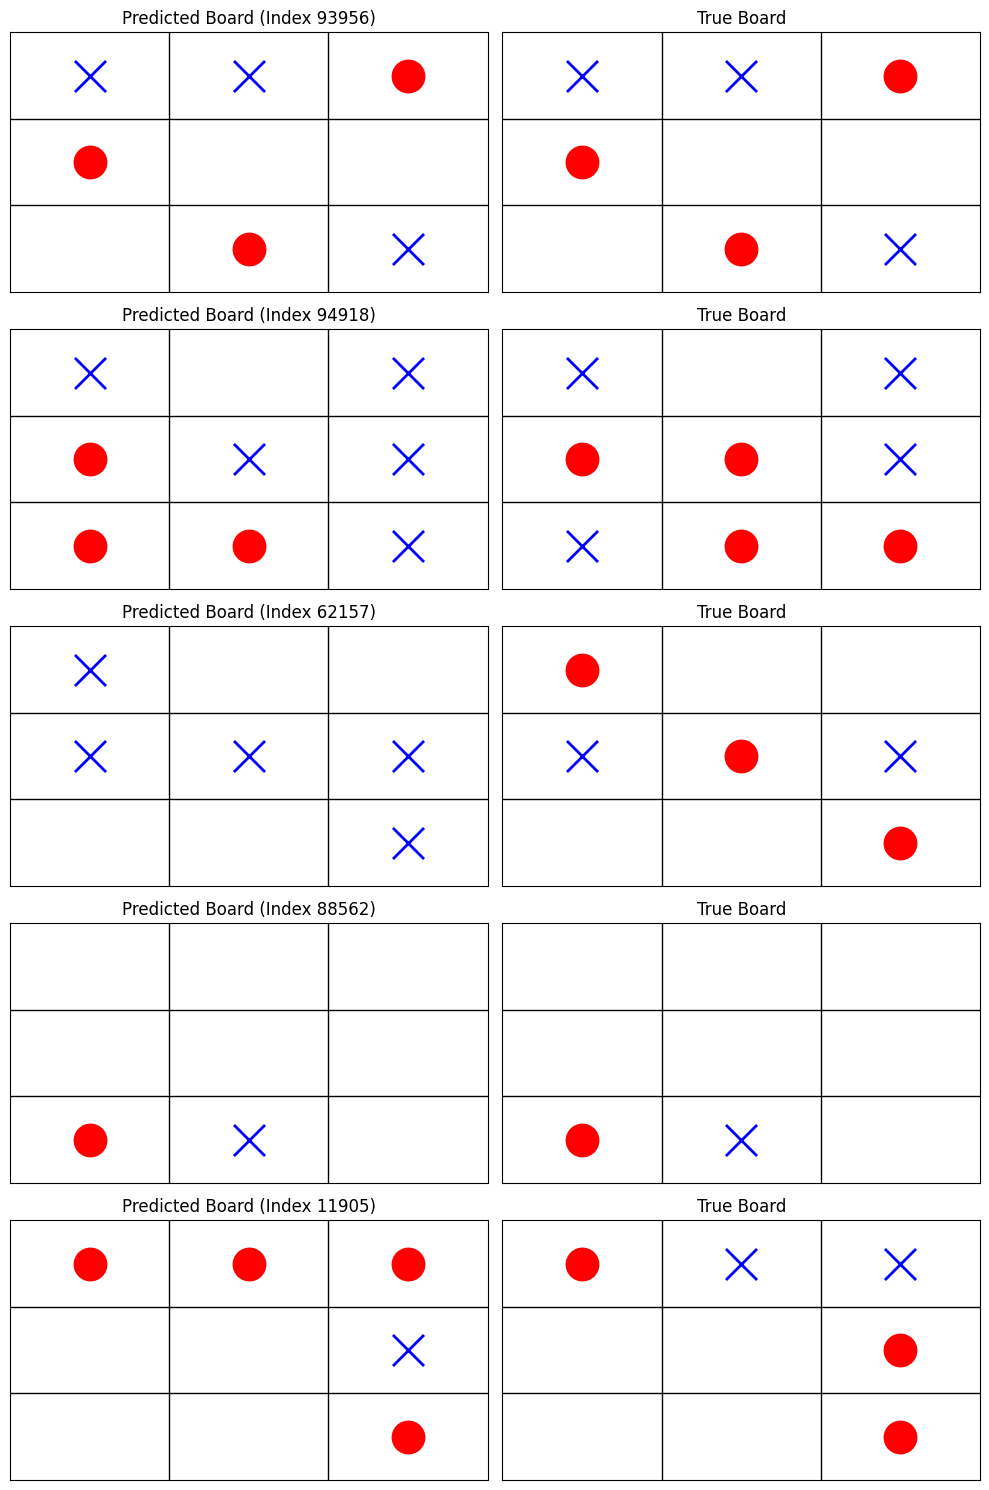

In [ ]:
def visualize_predictions(model, final_embeddings_tensor_sq, board_states_tensor, device, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        # Select one sample from final_embeddings_tensor_sq
        index = np.random.randint(0, len(final_embeddings_tensor_sq))  # Random index for demonstration
        sample_embedding = final_embeddings_tensor_sq[index].unsqueeze(0).to(device)  # Add batch dimension

        # Pass the sample through the model
        logits = model(sample_embedding)  # Shape: [1, 9 * 3]
        logits = logits.view(1, 9, 3)  # Reshape to [1, 9, 3]

        # Get the predicted classes
        predicted_classes = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()  # Shape: [9]

        # Get the ground truth board state
        true_board_state = board_states_tensor[index].cpu().numpy()

        # Plot predicted and true board states
        for ax, board, title in zip([axes[i, 0], axes[i, 1]], 
                                    [predicted_classes, true_board_state], 
                                    [f"Predicted Board (Index {index})", "True Board"]):
            ax.set_title(title)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlim(-0.5, 2.5)
            ax.set_ylim(2.5, -0.5)

            # Draw grid
            for x in range(1, 3):
                ax.axvline(x - 0.5, color="black", linewidth=1)
                ax.axhline(x - 0.5, color="black", linewidth=1)

            # Plot pieces
            for row in range(3):
                for col in range(3):
                    value = board[row * 3 + col]
                    if value == 1:
                        ax.scatter(col, row, s=500, c="blue", marker="x", linewidths=2)  # Blue "X"
                    elif value == 2:
                        ax.scatter(col, row, s=500, c="red", marker="o", edgecolors="red", facecolors="none", linewidths=2)  # Red "O"

    plt.tight_layout()
    plt.show()
    
visualize_predictions(model, final_embeddings_tensor_sq, board_states_tensor, device, num_samples=5)


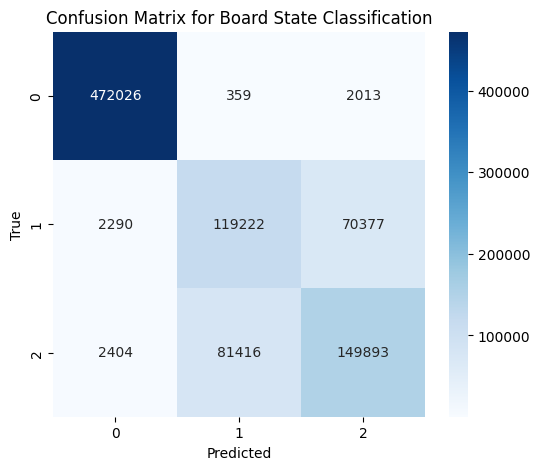

In [ ]:
def plot_confusion_matrix(model, final_embeddings_tensor_sq, board_states_tensor, device):
    model.eval()  # Set the model to evaluation mode
    
    all_preds = []
    all_true = []

    with torch.no_grad():
        for index in range(len(final_embeddings_tensor_sq)):
            sample_embedding = final_embeddings_tensor_sq[index].unsqueeze(0).to(device)
            logits = model(sample_embedding)
            logits = logits.view(1, 9, 3)
            predicted_classes = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()
            true_board_state = board_states_tensor[index].cpu().numpy()

            all_preds.extend(predicted_classes)
            all_true.extend(true_board_state)

    # Compute confusion matrix
    cm = confusion_matrix(all_true, all_preds, labels=[0, 1, 2])
    accuracy_per_space = (cm.diagonal() / cm.sum(axis=1)) * 100
    # print("Accuracy per board space:")
    # for i, acc in enumerate(accuracy_per_space):
    #     print(f"Board space {i}: {acc:.2f}%")
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1", "2"], yticklabels=["0", "1", "2"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix for Board State Classification')
    plt.show()

# Example usage
plot_confusion_matrix(model, final_embeddings_tensor_sq, board_states_tensor, device)

In [ ]:
player_based_board_from_seq([9, 7, 2, 6, 0, 8])

array([[ 1.,  0.,  1.],
       [ 0.,  0.,  0.],
       [-1., -1., -1.]])

In [ ]:
from probe_functions import run_probe_experiment
for n, name_opt in enumerate(['ckpt1', 'ckpt2', 'ckpt3', 'ckpt4']):
    (layer_num_to_results,
    train_board_states_tensor, test_board_states_tensor, 
    train_activations_list, test_activations_list) = run_probe_experiment(m, n, k, out_dir='probing_checkpoints', name=name_opt)

    print(f'Displaying results for checkpoint {n}')

    for i, layer_res in layer_num_to_results.items():
        print(f"Results from activations in layer {i + 1}")
        for j, dic in enumerate(layer_res):
            if j == 0:
                plt.plot(dic['mlp'], label='MLP Loss')
                plt.plot(dic['linear'], label='Linear Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Loss for MLP and Linear from layer {i + 1}')
                plt.legend()
                plt.show()
            elif j == 1:
                print(f"Final board accuracy for MLP = {dic['mlp']}")
                print(f"Final board accuracy for Linear = {dic['linear']}")
            elif j == 2:
                print(f"Final space accuracy for MLP = {dic['mlp']}")
                print(f"Final space accuracy for Linear = {dic['linear']}")
            elif j == 3:
                linear_model = dic
            elif j == 4:
                mlp_model = dic
            for model in [linear_model, mlp_model]:
                plot_confusion_matrix(model, test_activations_list, test_board_states_tensor, device=device)
        


/Users/rajenparekh/Desktop/Brown/2024-25/Senior Thesis/mnk_transformer/setup.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_loca

Model has 1 layers, 3 total embeddings
On sequence 0/100000
On sequence 1000/100000
On sequence 2000/100000
On sequence 3000/100000
On sequence 4000/100000
On sequence 5000/100000
On sequence 6000/100000
On sequence 7000/100000
On sequence 8000/100000
On sequence 9000/100000
On sequence 10000/100000
On sequence 11000/100000
On sequence 12000/100000
On sequence 13000/100000
On sequence 14000/100000
On sequence 15000/100000
On sequence 16000/100000
On sequence 17000/100000
On sequence 18000/100000
On sequence 19000/100000
On sequence 20000/100000
On sequence 21000/100000
On sequence 22000/100000
On sequence 23000/100000
On sequence 24000/100000
On sequence 25000/100000
On sequence 26000/100000
On sequence 27000/100000


KeyboardInterrupt: 

In [ ]:
res

{0: ({'mlp': [0.7472205487719271,
    0.6699539761053623,
    0.6671120047721814,
    0.6642071875104215,
    0.6627863278315759,
    0.6618717394993233,
    0.6609871225218245,
    0.6601261264875159,
    0.6593328102689024,
    0.6586146638397978,
    0.6579991482002797,
    0.6574252853390504,
    0.6570721045565467,
    0.6566296616046,
    0.6563275286347455,
    0.6561304281441279,
    0.6559639943004494,
    0.655721822516398,
    0.655693822233477,
    0.6555831949450004,
    0.655461387209456,
    0.655187890648613,
    0.6553706754039513,
    0.6552533686008503,
    0.6550931909567869,
    0.6551334823238033,
    0.6549177700063775,
    0.6550107783258381,
    0.6548833681159651,
    0.6548837870264084,
    0.6547972723336382,
    0.6548522626522331,
    0.6546691722848518,
    0.6547118403060422,
    0.6547007390839582,
    0.6546385724500289,
    0.6545650479470165,
    0.6545037293922268,
    0.6544939170109486,
    0.6544922788175191],
   'linear': [0.970818216153924,
   

In [ ]:
layer_0_res = res[0]
layer_1_res = res[1]
layer_2_res = res[2]

In [ ]:
res

{0: ({'mlp': [0.7472205487719271,
    0.6699539761053623,
    0.6671120047721814,
    0.6642071875104215,
    0.6627863278315759,
    0.6618717394993233,
    0.6609871225218245,
    0.6601261264875159,
    0.6593328102689024,
    0.6586146638397978,
    0.6579991482002797,
    0.6574252853390504,
    0.6570721045565467,
    0.6566296616046,
    0.6563275286347455,
    0.6561304281441279,
    0.6559639943004494,
    0.655721822516398,
    0.655693822233477,
    0.6555831949450004,
    0.655461387209456,
    0.655187890648613,
    0.6553706754039513,
    0.6552533686008503,
    0.6550931909567869,
    0.6551334823238033,
    0.6549177700063775,
    0.6550107783258381,
    0.6548833681159651,
    0.6548837870264084,
    0.6547972723336382,
    0.6548522626522331,
    0.6546691722848518,
    0.6547118403060422,
    0.6547007390839582,
    0.6546385724500289,
    0.6545650479470165,
    0.6545037293922268,
    0.6544939170109486,
    0.6544922788175191],
   'linear': [0.970818216153924,
   

Results from activations in layer 1


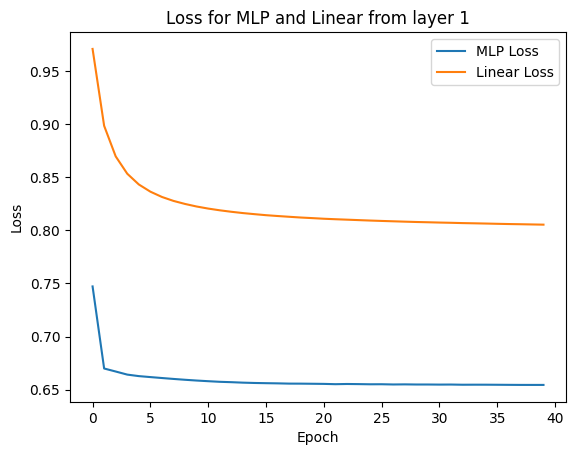

Final board accuracy for MLP = 0.20175
Final board accuracy for Linear = 0.20115
Final space accuracy for MLP = 0.6722944444444444
Final space accuracy for Linear = 0.6404555555555556
Results from activations in layer 2


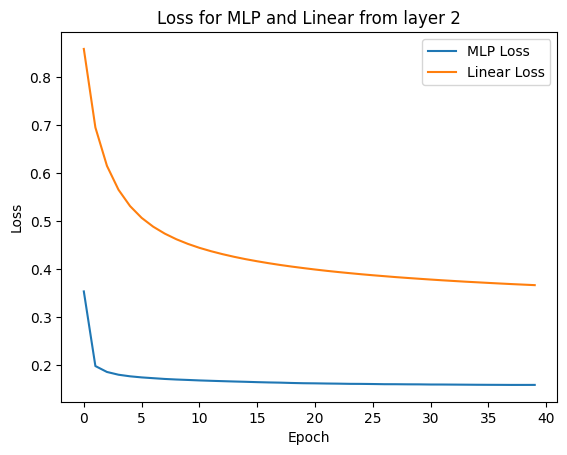

Final board accuracy for MLP = 0.82995
Final board accuracy for Linear = 0.5433
Final space accuracy for MLP = 0.91295
Final space accuracy for Linear = 0.8638388888888889
Results from activations in layer 3


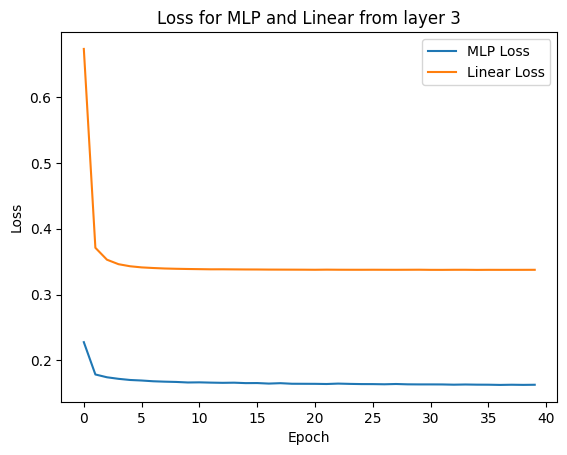

Final board accuracy for MLP = 0.82935
Final board accuracy for Linear = 0.5941
Final space accuracy for MLP = 0.9114
Final space accuracy for Linear = 0.8570222222222222


In [ ]:
for i, layer_res in res.items():
    print(f"Results from activations in layer {i + 1}")
    for j, dic in enumerate(layer_res):
        if j == 0:
            plt.plot(dic['mlp'], label='MLP Loss')
            plt.plot(dic['linear'], label='Linear Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'Loss for MLP and Linear from layer {i + 1}')
            plt.legend()
            plt.show()
        elif j == 1:
            print(f"Final board accuracy for MLP = {dic['mlp']}")
            print(f"Final board accuracy for Linear = {dic['linear']}")
        else:
            print(f"Final space accuracy for MLP = {dic['mlp']}")
            print(f"Final space accuracy for Linear = {dic['linear']}")
